In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky, search_around_sky
import astropy.units as u
from matplotlib import cm
import time
from numpy.random import default_rng

import healpy as hp
import pymaster as nmt
import pandas as pd

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations

Random subsample:

In [2]:
fn_stellar = '../data/stars_gaia_G19-20_bprp_0.3-0.7_rand1e8.fits.gz'
tab_stellar = Table.read(fn_stellar)

b_max = 30
idx_bcut = abs(tab_stellar['b']) > b_max
print(np.sum(idx_bcut)/len(idx_bcut))

tab_stellar_bcut = tab_stellar[idx_bcut]

0.5087046679876503


In [27]:
NSIDE = 64
map_nstars, _ = utils.get_map(NSIDE, tab_stellar['ra'], tab_stellar['dec'])

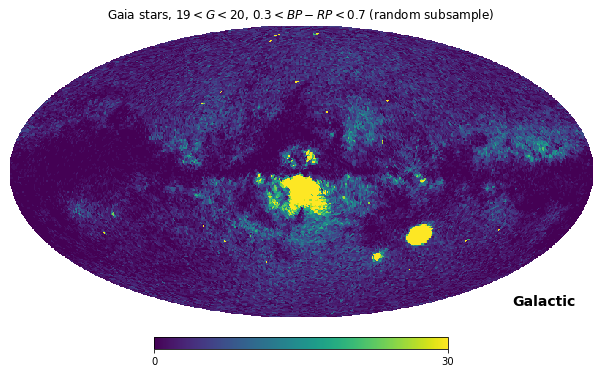

In [29]:
hp.mollview(map_nstars, title=r'Gaia stars, $19<G<20$, $0.3 < BP-RP < 0.7$ (random subsample)',
            coord=['C', 'G'], min=0, max=30)

Subsample with top:

In [3]:
# fn_stellar_bcut = '../data/stars_gaia_G19-20_bprp_0.3-0.7_bmax30_top1e5.fits.gz'
# tab_stellar_bcut = Table.read(fn_stellar_bcut)

In [25]:
print(len(tab_stellar_bcut))

110394


In [4]:
NSIDE = 64
map_nstars_bcut, _ = utils.get_map(NSIDE, tab_stellar_bcut['ra'], tab_stellar_bcut['dec'])

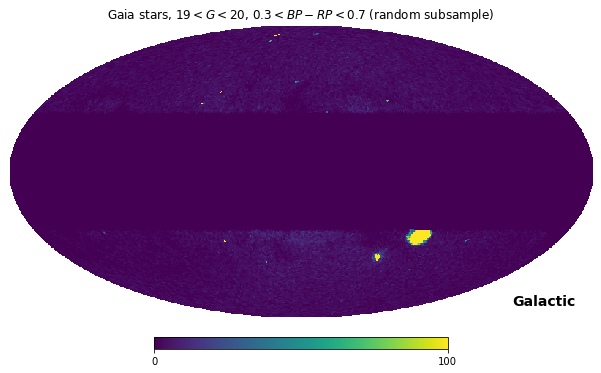

In [5]:
hp.mollview(map_nstars_bcut, title=r'Gaia stars, $19<G<20$, $0.3 < BP-RP < 0.7$ (random subsample)',
            coord=['C', 'G'], min=0, max=100)

Text(0, 0.5, 'number per bin')

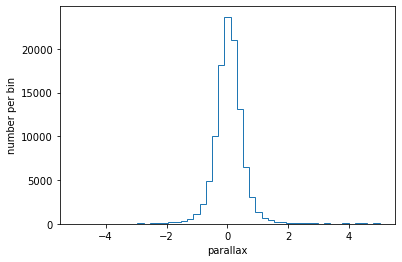

In [6]:
bins = np.linspace(-5, 5, 50)
plt.hist(tab_stellar_bcut['parallax'], bins=bins, histtype='step')
plt.xlabel('parallax')
plt.ylabel('number per bin')

In [7]:
coords = SkyCoord(tab_stellar_bcut['ra'], tab_stellar_bcut['dec'], frame='icrs')

In [8]:
seplimit = 5*u.arcsec
idx1, idx2, sep2d, _ = search_around_sky(coords, coords, seplimit=seplimit)

In [9]:
len(idx1), len(idx2), len(coords), len(sep2d)

(110704, 110704, 110394, 110704)

In [10]:
idx_sepnonzero = sep2d.to('arcsec').value > 1e-6
print(np.sum(idx_sepnonzero),np.sum(idx_sepnonzero)/len(idx_sepnonzero))

310 0.00280026015320133


In [11]:
idx_b1 = idx1[idx_sepnonzero]
idx_b2 = idx2[idx_sepnonzero]
print(len(idx_b1), len(idx_b2))

310 310


In [12]:
pairs = np.array(list(zip(idx_b1, idx_b2)))
pairs = np.sort(pairs, axis=1)

In [13]:
vals_unique, idx_unique = np.unique(pairs, return_index=True, axis=0)

In [14]:
idx_b1 = idx_b1[idx_unique]
idx_b2 = idx_b2[idx_unique]

Text(0, 0.5, 'number per bin')

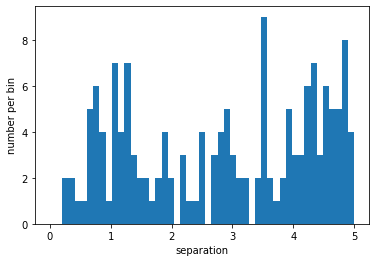

In [15]:
bins = np.linspace(0, 5, 50)
plt.hist(sep2d.to('arcsec').value[idx_sepnonzero][idx_unique], bins=bins)
plt.xlabel('separation')
plt.ylabel('number per bin')

In [16]:
pm_diffs = abs(tab_stellar_bcut['pm'][idx_b1] - tab_stellar_bcut['pm'][idx_b2])

In [17]:
prefac = 1/np.sqrt(tab_stellar_bcut['pmra']**2 + tab_stellar_bcut['pmdec']**2)
pm_error = prefac * np.sqrt((tab_stellar_bcut['pmra']*tab_stellar_bcut['pmra_error'])**2 + \
                            (tab_stellar_bcut['pmdec']*tab_stellar_bcut['pmdec_error'])**2)

In [18]:
n_sigma = 3
err_pm_diff = np.sqrt(pm_error[idx_b1]**2 + pm_error[idx_b2]**2)
sigma_diff = abs(tab_stellar_bcut['pm'][idx_b1] - tab_stellar_bcut['pm'][idx_b2]) / err_pm_diff
idx_pm_near = sigma_diff < n_sigma
print(len(idx_pm_near))
print(np.sum(idx_pm_near)/len(idx_pm_near))

155
0.6709677419354839


[]

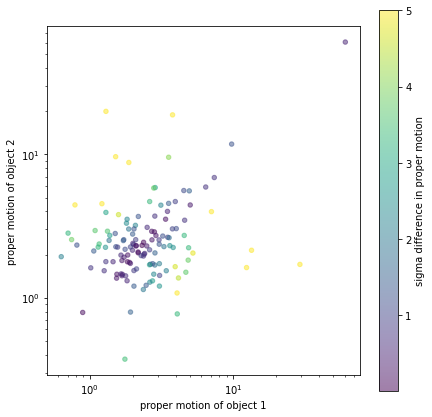

In [19]:
plt.figure(figsize=(7,7))
plt.scatter(tab_stellar_bcut['pm'][idx_b1], tab_stellar_bcut['pm'][idx_b2], s=20, alpha=0.5, c=sigma_diff, vmax=5)
plt.colorbar(label='sigma difference in proper motion')
plt.xlabel('proper motion of object 1')
plt.ylabel('proper motion of object 2')
ax = plt.gca()
ax.set_aspect('equal')
plt.loglog()

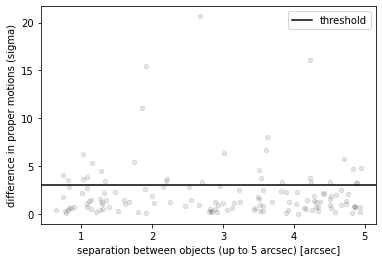

In [20]:
plt.scatter(sep2d.to('arcsec').value[idx_sepnonzero][idx_unique], sigma_diff, s=20, alpha=0.1, color='k')
plt.xlabel('separation between objects (up to 5 arcsec) [arcsec]')
plt.ylabel('difference in proper motions (sigma)')
plt.axhline(n_sigma, label='threshold', color='k')
plt.legend()

In [21]:
print(f"There are {len(idx_b1)} pairs in the catalog with separations less than {seplimit}.")
print(rf"Of these, {np.sum(idx_pm_near)} have proper motions within ${n_sigma}\sigma$ of each other.")

There are 155 pairs in the catalog with separations less than 5.0 arcsec.
Of these, 104 have proper motions within $3\sigma$ of each other.


In [22]:
NSIDE = 64
ra_b = np.concatenate((tab_stellar_bcut['ra'][idx_b1][idx_pm_near], tab_stellar_bcut['ra'][idx_b2][idx_pm_near]))
dec_b = np.concatenate((tab_stellar_bcut['dec'][idx_b1][idx_pm_near], tab_stellar_bcut['dec'][idx_b2][idx_pm_near]))
map_nstars_b, _ = utils.get_map(NSIDE, ra_b, dec_b)

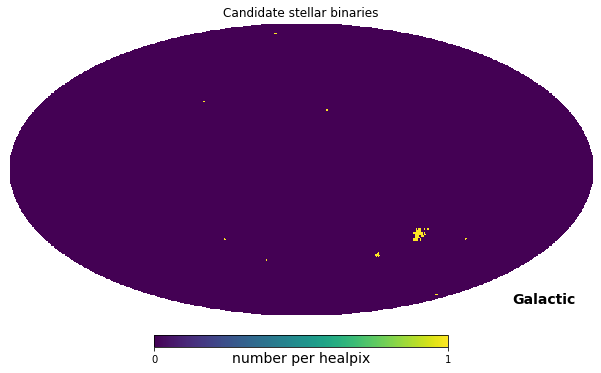

In [23]:
hp.mollview(map_nstars_b, title='Candidate stellar binaries', unit='number per healpix', 
            coord=['C', 'G'], min=0, max=1)

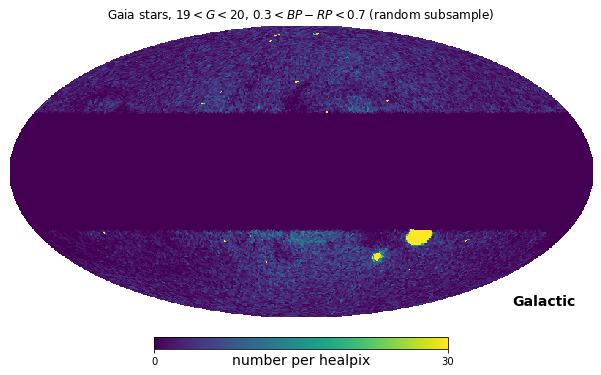

In [24]:
hp.mollview(map_nstars_bcut, title=r'Gaia stars, $19<G<20$, $0.3 < BP-RP < 0.7$ (random subsample)',
            unit='number per healpix', 
            coord=['C', 'G'], min=0, max=30)